In [2]:
# Imports needed in every section
import pandas as pd
import testing_scripts.constants as constants
%load_ext autoreload
%autoreload 2

# Section 1: Creating a labeled dataframe
This section involves reading in the resumes, filtering out entries whose CVs are too short, and creating positive and negative classes while filtering out all entries in neither class.

## From resumes parquet
This subsection assumes the existence of the resumes parquet file, processes, and exports the Labeled dataframe

In [34]:
# Read in the parquet
RESUMES_PARQUET_INPUT_FILENAME = "data/resumes.parquet"
raw_df = pd.read_parquet(RESUMES_PARQUET_INPUT_FILENAME, engine='pyarrow')  # raw dataframe

# Filter the dataframe by minimum cv length
MIN_CV_LENGTH = 500
filtered_df = raw_df.loc[raw_df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

# Add a true label column based on the specified keywords
import testing_scripts.label_resumes
labeled_df = filtered_df.copy()
testing_scripts.label_resumes.add_true_label_column(labeled_df, constants.POSITIVE_POSITIONS, constants.POSITIVE_KEYWORDS, constants.NEGATIVE_POSITIONS, constants.NEGATIVE_KEYWORDS)

# Filter out entries whose true label is NA (i.e. belongs to neither class)
labeled_df = labeled_df[labeled_df["True Label"].notna()]

# Export the labeled dataframe
LABELED_DATAFRAME_OUTPUT_FILENAME = "data/labeled_df_PM vs UI.csv"
labeled_df.to_csv(LABELED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the labeled_df.csv file already exists, run this instead to import the file

In [33]:
LABELED_DATAFRAME_INPUT_FILENAME = "data/labeled_df_PM vs UI.csv"
labeled_df = pd.read_csv(LABELED_DATAFRAME_INPUT_FILENAME)

## True label playground
This subsection contains some light code for examining the true label

In [35]:
# The size of the positive and negative classes
value_counts = labeled_df["True Label"].value_counts()
print(value_counts)

positiveClassSize = value_counts.get(constants.POSITIVE_LABEL, default=0)
negativeClassSize = value_counts.get(constants.NEGATIVE_LABEL, default=0)
print(f"Proportion of positives = {positiveClassSize / (positiveClassSize + negativeClassSize)}")

True Label
1    8897
0    6910
Name: count, dtype: int64
Proportion of positives = 0.562851901056494


In [36]:
# Example positive entry
example_positive_entry = labeled_df.loc[labeled_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_cv: str = example_positive_entry.to_dict()["CV"]
print(f"Truncated positive CV:\n====================\n {example_positive_cv[:1000]}...")

Truncated positive CV:
 During my work in a role of a Client Success Manager, I was responsible for the large US-based accounts health and growth. I used to work on 3 - 4 large enterprise-level accounts in parallel with the total number of dedicated engineering teams 30 – 50 people.
I've generated a lot of ideas for improvements, participated in building up strong engineering teams and working out the processes and strategy for the clients, which have resulted in the account and team growth.
I had a chance to mentor and inspire many people, who have later become talented engineers and solution architects, and learn from them as well.
- Managing multiple accounts with different engagement models. 
- Managing all aspects of client relationships. 
- Analyzing client's business pain-points, assisting with the roadmap to help reaching out strategic goals. 
- Taking active part in the whole opportunity initiation process. Drafting Proposals and SOWs.
- Extending partnership with the existing

In [38]:
# Example negative entry 
example_negative_entry = labeled_df.loc[labeled_df["True Label"] == constants.NEGATIVE_LABEL].iloc[0]
exampleNegativeCV = example_negative_entry.to_dict()["CV"]
print(f"Truncated negative CV:\n====================\n {exampleNegativeCV[:1000]}")

Truncated negative CV:
 
•   Possession of Adobe Photoshop, Adobe-AI, skills of working with a graphic tablet;
•   UI/UX ;
•.  Figma, Zeplin, Sketch, MarvelApp, Invision;
•   2D graphics (understanding of pixel and vector graphics and their specifics);
•.  2D Design;
•.  3D Max;
•   Ability to work in different styles;
•   Ability to draw by hand;
•   Creation of design banners, layouts, logos, frameworks and prototypes for websites and mobile applications;
•   Testing of games;
•   Making presentations in Power Point;
Availability of portfolio;
Bug tracking systems and project management tools: Trello and Jira.
I'm self-motivated artist with a strong skills at game industry. I have more 5 years experience in game company, and now, I want to broaden my world with interesting projects, to share own experience and to acquire new skills and knowledge.
So, my goal is putting into practice somebody's dreams, in so doing, working with pleasure.
I would like to work at company with friendly t

In [40]:
# Look at negative labeled entries
# labeled_df.loc[labeled_df["True Label"] == constants.NEGATIVE_LABEL]

# Section 2: Marking samples for Experiments
This section involves marking samples in the labeled dataframe for experiments. This allows us to experiment on a few samples at a time, rather than all entries at once.

## From labeled_df
This subsection assumes the existence of the labeled_df object within this notebook, processes, and exports the Marked dataframe

In [41]:
# How many samples from each class we want to mark for experiments
NUM_POSITIVE_SAMPLES = 0
NUM_NEGATIVE_SAMPLES = 100

# Create a new column "Marked for Experiments" and deterministically mark 
# the first NUM_POSITIVE_SAMPLES positive entries and the first NUM_NEGATIVE_SAMPLES negative entries True and all others false
marked_df = labeled_df.copy()
marked_df["Marked for Experiments"] = False
positive_sample_indices = marked_df[marked_df["True Label"] == constants.POSITIVE_LABEL].index[:NUM_POSITIVE_SAMPLES]
negative_sample_indices = marked_df[marked_df["True Label"] == constants.NEGATIVE_LABEL].index[:NUM_NEGATIVE_SAMPLES]
marked_df.loc[positive_sample_indices, "Marked for Experiments"] = True
marked_df.loc[negative_sample_indices, "Marked for Experiments"] = True

# Export the marked dataframe
MARKED_DATAFRAME_OUTPUT_FILENAME = "data/marked_df_100 UI.csv"
marked_df.to_csv(MARKED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the marked_df.csv file already exists, run this instead to import the file

In [12]:
MARKED_DATAFRAME_INPUT_FILENAME = "data/marked_df_100 UI.csv"
marked_df = pd.read_csv(MARKED_DATAFRAME_INPUT_FILENAME)

## Mark playground
This subsection contains some light code for examining the true label

In [46]:
# The total number of marked entries (should match NUM_POSITIVE_SAMPLES + NUM_NEGATIVE_SAMPLES)
value_counts = marked_df["Marked for Experiments"].value_counts()
print(f"Number of samples = {value_counts.get(True)}")

Number of samples = 100


# Section 3: Generating tailored resumes
This section involves generating resumes tailored toward a specific job over the samples marked for experiments

## From marked_df
This subsection assumes the existence of the marked_df object within this notebook and generates modified resumes tailored toward the job specified in constants.py

In [ ]:
# Add tailored resumes based on the job description using the chosen model
import testing_scripts.generate_resumes as generate_resumes
tailored_df = marked_df.copy()
generate_resumes.create_modified_resumes(tailored_df, job_name = constants.JOB_NAME, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME, verbose = True)

# Export the tailored dataframe
TAILORED_DATAFRAME_OUTPUT_FILENAME = "data/tailored_df.csv"
tailored_df.to_csv(TAILORED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the tailored_df.csv file already exists, run this instead to import the file

In [22]:
TAILORED_DATAFRAME_INPUT_FILENAME = "data/tailored_df.csv"
tailored_df = pd.read_csv(TAILORED_DATAFRAME_INPUT_FILENAME)

## Tailored resumes playground
This subsection contains some light code for examining the tailored resumes

In [33]:
example_positive_entry = tailored_df[tailored_df["Marked for Experiments"] & tailored_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_CV = example_positive_entry["CV"]
example_positive_tailored_CV = example_positive_entry[constants.tailored_cv_name(model_name = constants.MODEL_NAME, job_name = constants.JOB_NAME)]

print(f"Truncated positive CV:\n====================\n {example_positive_CV[:750]}...")
print(f"\n\nTruncated positive tailored CV:\n====================\n {example_positive_tailored_CV[:750]}...")
# print(f"Example positive CV = {example_positive_cv}\n\n")

# example_tailored_positive_cv = generate_resumes.tailor_resume(example_positive_cv, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME)
# print(f"Example positive tailored CV = {example_tailored_positive_cv}")

Truncated positive CV:
 High levels of self-organization, structure, and attention to detail have helped build a successful career in advertising, as evidenced by hundreds of successfully completed projects, and train dozens of specialists. Previous experience is similar to project management methodologies used in the IT industry, including budgeting, planning, stakeholder management, risk mitigation, and effective communication. Creating new products inspires and motivates further development.
Account director
2018 - 2021
Management and development of client portfolio. 
Control over project development and progress. 
Planning and budgeting based on client portfolio. 
Analysis of project effectiveness and profitability. 
Operational management: organizing, c...


Truncated positive tailored CV:
  **Account Director**

* Managed and developed client portfolio, including control over project development and progress, planning and budgeting based on client portfolio, analysis of project e

# Section 4: Scoring resumes
This section involves scoring the original and generated CVs

## From tailored_df
This subsection assumes the existence of the tailored_df object within this notebook and computes for both the original and generated CVs

In [48]:
# Add scores for both the original and generated CVs
import testing_scripts.score_resumes as score_resumes
# scored_df = tailored_df.copy()
scored_df = marked_df.copy()

score_resumes.append_scores(scored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = "CV", verbose = True)
# score_resumes.append_scores(scored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = constants.TAILORED_CV_NAME, verbose = True)

# Export the scored dataframe
SCORED_DATAFRAME_OUTPUT_FILENAME = "data/scored_df_100 UI.csv"
scored_df.to_csv(SCORED_DATAFRAME_OUTPUT_FILENAME)

Number of samples marked for experiments = 100
Scoring a new resume (0 scored so far)...


100%|██████████| 252M/252M [00:11<00:00, 22.3MiB/s] 


Scoring a new resume (1 scored so far)...
Scoring a new resume (2 scored so far)...
Scoring a new resume (3 scored so far)...
Scoring a new resume (4 scored so far)...
Scoring a new resume (5 scored so far)...
Scoring a new resume (6 scored so far)...
Scoring a new resume (7 scored so far)...
Scoring a new resume (8 scored so far)...
Scoring a new resume (9 scored so far)...
Scoring a new resume (10 scored so far)...
Scoring a new resume (11 scored so far)...
Scoring a new resume (12 scored so far)...
Scoring a new resume (13 scored so far)...
Scoring a new resume (14 scored so far)...
Scoring a new resume (15 scored so far)...
Scoring a new resume (16 scored so far)...
Scoring a new resume (17 scored so far)...
Scoring a new resume (18 scored so far)...
Scoring a new resume (19 scored so far)...
Scoring a new resume (20 scored so far)...
Scoring a new resume (21 scored so far)...
Scoring a new resume (22 scored so far)...
Scoring a new resume (23 scored so far)...
Scoring a new resume

## From import
If the scored_df.csv file already exists, run this instead to import the file

In [3]:
SCORED_DATAFRAME_INPUT_FILENAME = "data/scored_df_100 UI.csv"
scored_df = pd.read_csv(SCORED_DATAFRAME_INPUT_FILENAME)

## Scored resumes playground
This subsection contains some light code for examining the resume scores

In [49]:
# Extract original CV score series
original_cv_scores: pd.Series = scored_df.loc[scored_df["CV Score"].notna(),"CV Score"]

ORIGINAL_CV_SCORES_OUTPUT_FILENAME = "data/100 original UI CV scores.csv"
original_cv_scores.to_csv(ORIGINAL_CV_SCORES_OUTPUT_FILENAME)

In [3]:
# Import each type
# Import the original positive CS scores from a file
ORIGINAL_POSITIVE_SCORES_INPUT_FILENAME = "data/100 original PM CV scores.csv"
ORIGINAL_NEGATIVE_SCORES_INPUT_FILENAME = "data/100 original UI CV scores.csv"

original_positive_cv_scores: pd.Series = pd.read_csv(ORIGINAL_POSITIVE_SCORES_INPUT_FILENAME)["CV Score"]
original_negative_cv_scores: pd.Series = pd.read_csv(ORIGINAL_NEGATIVE_SCORES_INPUT_FILENAME)["CV Score"]


PM mean = 84.22895999999999, std = 3.05162948993458
UI mean = 79.35987, std = 2.2062479674869735


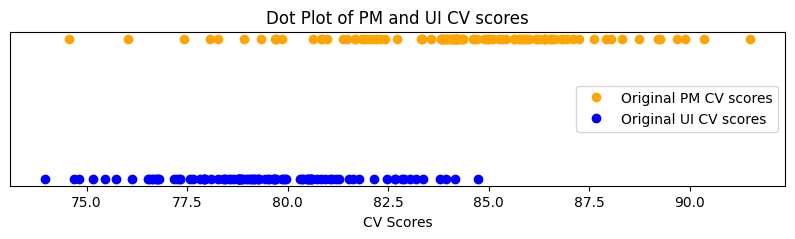

In [4]:
positive_mean = original_positive_cv_scores.mean()
positive_std = original_positive_cv_scores.std()
negative_mean = original_negative_cv_scores.mean()
negative_std = original_negative_cv_scores.std()

print(f"PM mean = {positive_mean}, std = {positive_std}")
print(f"UI mean = {negative_mean}, std = {negative_std}")

import numpy as np
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Plot the positive scores
ax.plot(original_positive_cv_scores, np.ones_like(original_positive_cv_scores), 'o', color='orange', label='Original PM CV scores')

# Plot the negative scores
ax.plot(original_negative_cv_scores, np.zeros_like(original_negative_cv_scores), 'o', color='blue', label='Original UI CV scores')

# Set y-ticks to be hidden to make it look like a 1-dimensional plot
ax.set_yticks([])

# Add labels and title
ax.set_xlabel('CV Scores')
ax.set_title('Dot Plot of PM and UI CV scores')

# Add a legend
ax.legend(loc='center right')

# Display the plot
plt.show()


In [23]:
# Sorted in descending order (this makes computing certain quantities easier)
sorted_positive_scores = sorted(original_positive_cv_scores.values.tolist(), reverse = True)
sorted_negative_scores = sorted(original_negative_cv_scores.values.tolist(), reverse = True)


# # Test
# sorted_positive_scores = sorted([1, 3, 6, 10], reverse = True)
# sorted_negative_scores = sorted([2, 4, 5], reverse = True)


num_positive_scores = len(sorted_positive_scores)
num_negative_scores = len(sorted_negative_scores)

In [38]:
# Using a threshold, computes the optimal accuracy based on these two groups (no edits/manipulation)

# To compute the accuracy,
# 1. Sort each list of scores       --> bottleneck
# 2. Start with -infty. Initialize confusion matrix
# 3. Choose the next smallest element from either list
# 4. Update the confusion matrix accordingly
# 5. Compute the accuracy and store the values with the best

current_threshold = 101

# Minimum threshold means all are classified as positive
current_true_positives = 0
current_true_negatives = num_negative_scores

optimal_accuracy = 0

positive_iterator = iter(sorted_positive_scores)
negative_iterator = iter(sorted_negative_scores)

positive_element = next(positive_iterator, None)     # do None if no more remaining
negative_element = next(negative_iterator, None)

while positive_element is not None and negative_element is not None:
    # Select the maximum of the next entries and update the confusion matrix
    if positive_element >= negative_element:
        current_threshold = positive_element
        positive_element = next(positive_iterator, None)
        
        # All that changes is that a new positive value is accepted, so TP increases
        current_true_positives += 1
    
    else:
        current_threshold = negative_element
        negative_element = next(negative_iterator, None)
        
        # All the changes is that a new negative value is accepted, so TN decreases
        current_true_negatives -= 1

    # print(f"\nThreshold = {current_threshold}\n\tTP = {current_true_positives}\n\tTN = {current_true_negatives}")
    

    # Compute the accuracy
    current_accuracy = (current_true_positives + current_true_negatives) / (num_positive_scores + num_negative_scores)

    if current_accuracy >= optimal_accuracy:
        optimal_accuracy = current_accuracy
        optimal_threshold = current_threshold

        optimal_true_positives = current_true_positives
        optimal_true_negatives = current_true_negatives

print(f"Optimal accuracy = {optimal_accuracy}, optimal threshold = {optimal_threshold}, optimal TPR = {optimal_true_positives}/{num_positive_scores}, optimal TNR = {optimal_true_negatives}/{num_negative_scores}")

# Check TPs and TNs
# print(len([score for score in original_positive_cv_scores if score >= optimal_threshold]))
# print(len([score for score in original_negative_cv_scores if score < optimal_threshold]))

Optimal accuracy = 0.845, optimal threshold = 81.378, optimal TPR = 85/100, optimal TNR = 84/100


In [40]:
# Compute the conservatively optimal TPR
conservatively_optimal_TP = len([score for score in original_positive_cv_scores if score > max(original_negative_cv_scores)])
print(f"Conservatively optimal TPR = {conservatively_optimal_TP}/{num_positive_scores}")

Conservatively optimal TPR = 43/100


Slope: 0.2839985379977161
Intercept: 65.89054184151746
Coefficient of determination: 0.07413114259025322


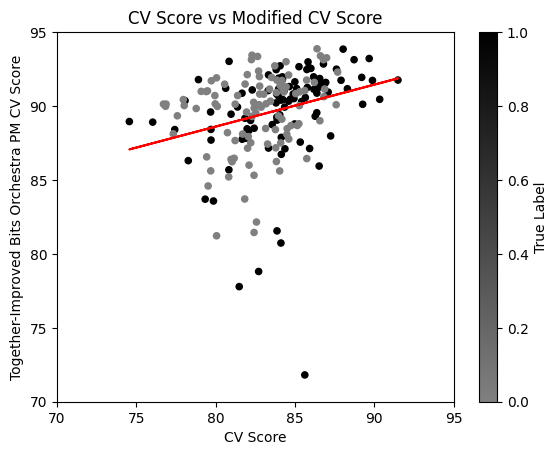

In [91]:
# # Create a scatterplot of original score vs improved score
# original_score_column_name = "CV Score"
# modified_score_column_name = f"{constants.TAILORED_CV_NAME} Score"

# all_scatterpoints: pd.DataFrame = scored_df.loc[scored_df["Marked for Experiments"], [original_score_column_name, modified_score_column_name, "True Label"]]

# # Portray positive label as black and negative label as gray
# from matplotlib.colors import LinearSegmentedColormap
# POSITIVE_SCATTERPOINT_COLOR = "black"
# NEGATIVE_SCATTERPOINT_COLOR = "gray"
# positive_negative_colormap = LinearSegmentedColormap.from_list("Positive-Negative", [(constants.NEGATIVE_LABEL, NEGATIVE_SCATTERPOINT_COLOR), (constants.POSITIVE_LABEL, POSITIVE_SCATTERPOINT_COLOR)])

# # Take nice square graph boundaries
# x_min = all_scatterpoints[original_score_column_name].min()
# x_max = all_scatterpoints[original_score_column_name].max()
# y_min = all_scatterpoints[modified_score_column_name].min()
# y_max = all_scatterpoints[modified_score_column_name].max()

# import math
# INCREMENT = 5
# lower_boundary = math.floor( (min(x_min, y_min) - 0.1) / INCREMENT) * INCREMENT
# upper_boundary = math.ceil( (max(x_max, y_max) + 0.1) / INCREMENT) * INCREMENT

# score_scatterplot_axes = all_scatterpoints.plot.scatter(x = original_score_column_name, y = modified_score_column_name, 
#                                                     c = "True Label", colormap = positive_negative_colormap,
#                                                     title = "CV Score vs Modified CV Score",
#                                                     xlim = (lower_boundary, upper_boundary), ylim = (lower_boundary, upper_boundary)
#                                                     )

# # Run linear regression on the combined 200 points
# from sklearn.linear_model import LinearRegression
# X = all_scatterpoints[[original_score_column_name]].values      # Reshaped into 2D array
# y = all_scatterpoints[modified_score_column_name].values        # 1D array

# linear_regression_model = LinearRegression()
# linear_regression_model.fit(X, y)

# # Get the coefficients
# linear_regression_slope = linear_regression_model.coef_[0]
# linear_regression_intercept = linear_regression_model.intercept_
# linear_regression_coefficient_of_determination = linear_regression_model.score(X, y)

# print(f"Slope: {linear_regression_slope}")
# print(f"Intercept: {linear_regression_intercept}")
# print(f"Coefficient of determination: {linear_regression_coefficient_of_determination}")

# # Plot the combined plot
# import matplotlib.pyplot as plt
# predictions = linear_regression_model.predict(X)
# score_scatterplot_axes.plot(X, predictions, color='red', label='Regression Line')

# plt.show()

In [63]:
# PM_scored_df = pd.read_csv("data/scored_df.csv")

In [70]:
# original_positive_cv_scores = PM_scored_df.loc[PM_scored_df["Marked for Experiments"] & PM_scored_df["True Label"] == constants.POSITIVE_LABEL, "CV Score"]
original_positive_cv_scores.to_csv(ORIGINAL_POSITIVE_SCORES_INPUT_FILENAME)